

#   **DESARROLLO DE UN MODELO DE MACHINE LEARNING**

## Proceso

### Seleccionamos un tema de interes
El tema de este proyecto se centra en el tratamiento de un dataset, el cual contiene datos sobre los pacientes de covid-19 en el Ecuador. Se intenta mejorar o optimizar los resultados de una investigacion previamente desarrollada sobre el mismo tema.

### Buscamos un artículo de base referente al tema: 

Articulo: https://revistas.unal.edu.co/index.php/revfacmed/article/view/86476

Dentro del paper anterior se observa la utilizacion de metodos correspondientes al modelo de probabilidad
discreta de Poisson.
Haciendo uso de una base de datos con la cual analizaron todos
los casos de COVID-19 confirmados oficialmente en Ecuador entre el 13 de marzo y el 2 de abril de 2020. 

### Buscamos y cargamos un dataset

Se utilizo un dataset basado en el articulo base encontrado, el cual nos muestra las cifras, desde el "29-02-2020" hasta el "23-07-2020", de la cantidad de personas contagiadas dentro del Ecuador:

Dataset: https://covid19.who.int/region/amro/country/ec

### Desarrollamos el procesamiento de datos

In [20]:
#Importamos todas las librerias que utilizaremos en el programa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
from timeit import timeit
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from timeit import default_timer
import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split


In [21]:
#Realizamos la carga del dataset, asignandole a cada columna sus respectivas etiquetas
#dataset = "2.COVID19_clasificacion.xlsx"

dataset = '2.COVID19_clasificacion.xlsx'
col = ['Number','Age','Gender','Fever','Dyspnea','Nasal','Cough','PO2','CRP','Asthenia','Leukopenia','Exposicion_Covid19_paciente',
       'High_risk_zone','Temperatura','Blood Test','PT-PCR','History','Label']
df = pd.read_excel(dataset, names=col)
df = df.iloc[1:]
df.head()

,Number,Age,Gender,Fever,Dyspnea,Nasal,Cough,PO2,CRP,Asthenia,Leukopenia,Exposicion_Covid19_paciente,High_risk_zone,Temperatura,Blood Test,PT-PCR,History,Label
1,2,62,Male,Yes,*,Yes,Yes,97,0.75,Yes,*,*,*,*,*,*,*,COVID-19
2,3,57,Male,Yes,*,Yes,Yes,*,*,*,*,Yes,*,*,*,*,*,COVID-19
3,4,45,Male,Yes,*,Yes,Yes,*,*,*,Yes,Yes,*,*,*,*,*,COVID-19
4,5,63,Male,Yes,*,Yes,Yes,*,*,*,Yes,Yes,*,*,*,*,*,COVID-19
5,6,32,Female,Yes,Yes,*,Yes,*,*,*,Yes,No,*,*,*,*,*,COVID-19


In [22]:
#Remplazamos los valores nulos, en este caso representados con un " * ".Los sustituimos por " -1 ".

#Ademas asignamos constantes numericas a los valores aignados como "Yes/No",
#los remplazamos por "No=0", "Yes=1". 

#Y, en este caso, remplazamos las las constantes "Male/Female" por: "Male=0", "Female=1".

df['Age'] =df['Age'].replace(to_replace={'*':-1})
df['Gender'] =df['Gender'].replace(to_replace={'*':-1})
df['Dyspnea'] =df['Dyspnea'].replace(to_replace={'*':-1})
df['Nasal'] =df['Nasal'].replace(to_replace={'*':-1})
df['Fever'] =df['Fever'].replace(to_replace={'*':-1})
df['PO2'] =df['PO2'].replace(to_replace={'*':-1})
df['CRP'] =df['CRP'].replace(to_replace={'*':-1})
df['Asthenia'] =df['Asthenia'].replace(to_replace={'*':-1})
df['Leukopenia'] =df['Leukopenia'].replace(to_replace={'*':-1})
df['Exposicion_Covid19_paciente'] =df['Exposicion_Covid19_paciente'].replace(to_replace={'*':-1})
df['High_risk_zone'] =df['High_risk_zone'].replace(to_replace={'*':-1})
df['Temperatura'] =df['Temperatura'].replace(to_replace={'*':-1})
df['Blood Test'] =df['Blood Test'].replace(to_replace={'*':-1})
df['PT-PCR'] =df['PT-PCR'].replace(to_replace={'*':-1})
df['Cough'] =df['Cough'].replace(to_replace={'*':-1})

df['Dyspnea'] =df['Dyspnea'].replace(to_replace={'Yes':1})
df['Dyspnea'] =df['Dyspnea'].replace(to_replace={'No':0})

df['Gender'] =df['Gender'].replace(to_replace={'Female':1})
df['Gender'] =df['Gender'].replace(to_replace={'Male':0})

df['Fever'] =df['Fever'].replace(to_replace={'Yes':1})
df['Fever'] =df['Fever'].replace(to_replace={'No':0})

df['Nasal'] =df['Nasal'].replace(to_replace={'Yes':1})
df['Nasal'] =df['Nasal'].replace(to_replace={'No':0})

df['Cough'] =df['Cough'].replace(to_replace={'Yes':1})
df['Cough'] =df['Cough'].replace(to_replace={'No':0})

df['Asthenia'] =df['Asthenia'].replace(to_replace={'Yes':1})
df['Asthenia'] =df['Asthenia'].replace(to_replace={'No':0})

df['Leukopenia'] =df['Leukopenia'].replace(to_replace={'Yes':1})

df['Exposicion_Covid19_paciente'] =df['Exposicion_Covid19_paciente'].replace(to_replace={'Yes':1})
df['Exposicion_Covid19_paciente'] =df['Exposicion_Covid19_paciente'].replace(to_replace={'No':0})

df['High_risk_zone'] =df['High_risk_zone'].replace(to_replace={'Yes':1})

df['Label'] =df['Label'].replace(to_replace={'COVID-19':1})
df['Label'] =df['Label'].replace(to_replace={'Flu':0})



df.head()

,Number,Age,Gender,Fever,Dyspnea,Nasal,Cough,PO2,CRP,Asthenia,Leukopenia,Exposicion_Covid19_paciente,High_risk_zone,Temperatura,Blood Test,PT-PCR,History,Label
1,2,62.0,0,1,-1,1,1,97.0,0.75,1,-1,-1,-1,-1.0,-1,-1,*,1
2,3,57.0,0,1,-1,1,1,-1.0,-1.00,-1,-1,1,-1,-1.0,-1,-1,*,1
3,4,45.0,0,1,-1,1,1,-1.0,-1.00,-1,1,1,-1,-1.0,-1,-1,*,1
4,5,63.0,0,1,-1,1,1,-1.0,-1.00,-1,1,1,-1,-1.0,-1,-1,*,1
5,6,32.0,1,1,1,-1,1,-1.0,-1.00,-1,1,0,-1,-1.0,-1,-1,*,1


In [23]:
#Eliminamos las columnas que producen ruido dentro de nuestro analisis y no aportana a nuestra investigacion.
df=df.drop(['History','Number','PT-PCR','Blood Test'], axis=1)
df.head()

,Age,Gender,Fever,Dyspnea,Nasal,Cough,PO2,CRP,Asthenia,Leukopenia,Exposicion_Covid19_paciente,High_risk_zone,Temperatura,Label
1,62.0,0,1,-1,1,1,97.0,0.75,1,-1,-1,-1,-1.0,1
2,57.0,0,1,-1,1,1,-1.0,-1.00,-1,-1,1,-1,-1.0,1
3,45.0,0,1,-1,1,1,-1.0,-1.00,-1,1,1,-1,-1.0,1
4,63.0,0,1,-1,1,1,-1.0,-1.00,-1,1,1,-1,-1.0,1
5,32.0,1,1,1,-1,1,-1.0,-1.00,-1,1,0,-1,-1.0,1


In [24]:
#Seleccionamos las variables independientes y las separamos de la independiente, de esta forma:

Xsubset = df[['Age','Gender','Fever','Dyspnea','Nasal','Cough','PO2','CRP','Asthenia','Leukopenia','Exposicion_Covid19_paciente',
       'High_risk_zone','Temperatura']]

y = df.Label.values
print(Xsubset)
type(Xsubset)

      Age  Gender  ...  High_risk_zone  Temperatura
1    62.0       0  ...              -1         -1.0
2    57.0       0  ...              -1         -1.0
3    45.0       0  ...              -1         -1.0
4    63.0       0  ...              -1         -1.0
5    32.0       1  ...              -1         -1.0
..    ...     ...  ...             ...          ...
125  62.0       1  ...               1         38.3
126  63.0       0  ...               1         38.5
127  63.0       1  ...               1         39.3
128  40.0       1  ...               1         -1.0
129  78.0       1  ...               1         36.7

[129 rows x 13 columns]


pandas.core.frame.DataFrame

In [26]:
#Ahora, se separan las variables "Ordinales" de las "Nominales". Para ello hacemos uso de
# el metod StandardScaler para las nominales y el metodo OneHotEncoder para las ordinales.
preprocesador1 = make_column_transformer(
    (StandardScaler(),['Age','PO2','CRP','Temperatura']),
    (OneHotEncoder(),['Gender','Fever','Dyspnea','Nasal','Cough','Asthenia','Leukopenia','Exposicion_Covid19_paciente','High_risk_zone']))

X = preprocesador1.fit_transform(Xsubset)
print(X.shape[1])
print(X.shape)

categorical_features = ['Gender','Fever','Dyspnea','Nasal','Cough','Asthenia','Leukopenia','Exposicion_Covid19_paciente','High_risk_zone']
cnamesDataset1 = ['Age','PO2','CRP','Temperatura']
cnamesDataset2 = preprocesador1.transformers_[1][1].get_feature_names(categorical_features)

cnamesDataset1.extend(cnamesDataset2)
print(cnamesDataset1)

DatasetPreprocesado = pd.DataFrame(data=X,columns=cnamesDataset1)


print(DatasetPreprocesado.head())


#En esta parte generamos un documento ".csv" para poder registrar y observar como se distribuyen los datos ya organizados
DatasetPreprocesado.to_csv("DatasetPreprocesados.csv", sep=";",index = False) 

29
(129, 29)
['Age', 'PO2', 'CRP', 'Temperatura', 'Gender_-1', 'Gender_0', 'Gender_1', 'Fever_-1', 'Fever_0', 'Fever_1', 'Dyspnea_-1', 'Dyspnea_0', 'Dyspnea_1', 'Nasal_-1', 'Nasal_0', 'Nasal_1', 'Cough_-1', 'Cough_0', 'Cough_1', 'Asthenia_-1', 'Asthenia_0', 'Asthenia_1', 'Leukopenia_-1', 'Leukopenia_1', 'Exposicion_Covid19_paciente_-1', 'Exposicion_Covid19_paciente_0', 'Exposicion_Covid19_paciente_1', 'High_risk_zone_-1', 'High_risk_zone_1']
        Age       PO2  ...  High_risk_zone_-1  High_risk_zone_1
0  0.173531  1.857513  ...                1.0               0.0
1 -0.082128 -0.455209  ...                1.0               0.0
2 -0.695709 -0.455209  ...                1.0               0.0
3  0.224663 -0.455209  ...                1.0               0.0
4 -1.360422 -0.455209  ...                1.0               0.0

[5 rows x 29 columns]


### Realizamos un Split con 20% en Test

In [27]:
#Train: entrenaremos nuestro modelo en este conjunto de datos.
#Test: utilizaremos este subconjunto para hacer predicciones reales usando un modelo entrenado.
#Ahora preparamos el perceptron, importando las neuronas simples y el modelo secuencial.
#Division train y test, con un split en el test del 20%:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)


In [28]:
X_train.shape[1]

29

In [29]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(103, 29) (26, 29) (103,) (26,)


###Diseñamos un modelo de Machine Learning.

In [30]:
#FUNCIONES PARA GuARDAR Y CARGAR CUALQUIER MODELO
def guardarRNN(model,nombreArchivoModelo,nombreArchivoPesos):
    print("Red Neuronal Grabada en Archivo")   
    
def cargarRNN(nombreArchivoModelo,nombreArchivoPesos):
   return model

In [31]:
#Construcción del Modelo o Arquitectura de Redes Neoronales
model = Sequential()

#La primera capa Dense recibe el numero de variables, que es la segunda dimensión de la matriz X, esto es X_train.shape[1]
#La primera capa tiene 32 neuronas. La función de activación es la función rectificadora.
model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
#La segunda capa tiene 64 neuronas. La función de activación es la función rectificadora.
model.add(Dense(64, activation='relu'))

#La capa de salida tiene 1 neurona. La capa de salida debe tener la misma dimensión como de cantidad de salidas queremos,
#por ejemplo, en este caso la salida "Covid-19_Label" solo requiere 0 y 1. Puesto que 0 o 1 ocupan solo un valor dentro de cada dato,
#entonces 1 neurona es suficiente. La función de activación es sigmoide para clasificación por probabilidad.
model.add(Dense(1, activation='sigmoid'))

#Como tenemos dos posibles salidas "0 o 1", vamos a escoger que el error lo trate como una clasificación binaria, 
#el optimizador será nuestra función derivada que nos ayudará a determinar hacia donde mover los pesos.
#ADADELTA: An Adaptive Learning Rate Method
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['acc']) 

#imprimir arquitectura de la red
model.summary()

#Entrenamiento: 

#Entrenaremos por 100 epochs, el batch_size es un argumento importante, porque representa cada cuántos datos va a actualizar
#los pesos. Este es el método del gradiente descendiente estocástico que hace el proceso más eficiente y preciso.
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)
score = model.evaluate(X_train, y_train, verbose=0)


inicio  = default_timer()

print('Resultado en Train:')
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

fin = default_timer()
print ('Timepo de ejecucion del entrenamiento: ', fin - inicio)


#Fase de Testing
score = model.evaluate(X_test, y_test, verbose=0)

inicio  = default_timer()

print('Resultado en Test:')
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

fin = default_timer()
print ('Timepo de ejecucion de la prueba: ', fin - inicio)

#Guardar la arquitectura de la red en un archivo 

nombreArchivoModelo='arquitectura_prueba'
nombreArchivoPesos='pesos_prueba'
guardarRNN(model,nombreArchivoModelo,nombreArchivoPesos)

inicio  = default_timer()
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

fin = default_timer()
print ('Timepo de ejecucion Completo: ', fin - inicio)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________
Resultado en Train:
acc: 100.00%
Timepo de ejecucion del entrenamiento:  0.0003508289999558656
Resultado en Test:
acc: 100.00%
Timepo de ejecucion de la prueba:  0.0002689940000095703
Red Neuronal Grabada en Archivo
acc: 100.00%
Timepo de ejecucion Completo:  0.00010691400001405782


In [32]:
#Comprobamos el tipo de cada una de las variables
df.dtypes

Age                            float64
Gender                           int64
Fever                            int64
Dyspnea                          int64
Nasal                            int64
Cough                            int64
PO2                            float64
CRP                            float64
Asthenia                         int64
Leukopenia                       int64
Exposicion_Covid19_paciente      int64
High_risk_zone                   int64
Temperatura                    float64
Label                            int64
dtype: object

In [33]:
#Predicciones con nuevos datos

#La siguiente función tomará los datos de entrada, los va a integrar a una dataframe, los va a preprocesar, y 
#retornará una predicción con la salida "0" o "1", es decir, "no tiene covid-19" o "tiene covid-19"
def predict(Age=57.0, Gender=1, Fever=1, Dyspnea=1, Nasal=1, Cough=1, PO2=61.3, CRP=0.75, Asthenia=1, Leukopenia=1,
            Exposicion_Covid19_paciente=1, High_risk_zone=1, Temperatura=-1.0):
    cnames = ['Age','Gender','Fever','Dyspnea','Nasal','Cough','PO2','CRP','Asthenia','Leukopenia','Exposicion_Covid19_paciente','High_risk_zone','Temperatura']
    data = [[Age,Gender,Fever,Dyspnea,Nasal,Cough,PO2,CRP,Asthenia,Leukopenia,Exposicion_Covid19_paciente,High_risk_zone,Temperatura]]
    my_X = pd.DataFrame(data=data, columns=cnames)
    my_X = preprocesador1.transform(my_X)
    return model.predict_classes(my_X)

inicio  = default_timer()




print('Predicción:',predict(Age=57.0, Gender=1, Fever=1, Dyspnea=1, Nasal=1, Cough=1, PO2=61.3, CRP=0.75, Asthenia=1, 
                            Leukopenia=1, Exposicion_Covid19_paciente=1, High_risk_zone=1, Temperatura=-1.0))

print('Predicción:',predict(Age=18.0, Gender=0, Fever=1, Dyspnea=1, Nasal=0, Cough=1, PO2=32.0, CRP=-1.0, Asthenia=1, 
                            Leukopenia=1, Exposicion_Covid19_paciente=1, High_risk_zone=-1.0, Temperatura=36.0))
fin = default_timer()
print ('Timepo de ejecucion: ', fin - inicio)

Predicción: [[1]]
Predicción: [[1]]
Timepo de ejecucion:  0.055873176000034164


## Metodo Propuesto

In [34]:
#Elbow Method
x1=[]
x2=[]

with open('DatasetPreprocesado.csv', 'r') as csvfile:
    plots= csv.reader(csvfile, delimiter=',')
    for row in plots:
        x1.append(int(row[0]))
        x2.append(int(row[1]))

In [35]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

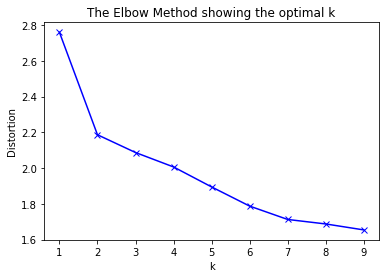

Timepo de ejecucion:  0.1680432480000036


In [36]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
inicio  = default_timer()

plt.show()
fin = default_timer()
print ('Timepo de ejecucion: ', fin - inicio)

In [37]:
#Estandarizacion de los datos
x=df
x = StandardScaler().fit_transform(x)

In [38]:
#PCA con todos los datos
pca = PCA()
principalComponents = pca.fit_transform(x)
principalComponents

num_components=principalComponents.shape[1]
num_components
explained_variance_ratio_=pca.explained_variance_ratio_
explained_variance_ratio_
#print('Varianzas:')
#print(np.around(explained_variance_ratio_, decimals=3))

a = range(1,num_components+1)
num_pc= a[::1]

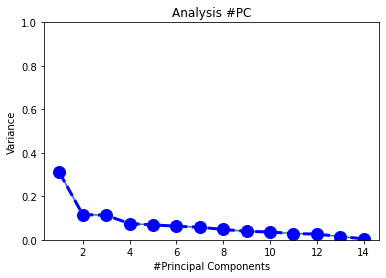

In [39]:
#Visualizar en 2D


plt.plot(num_pc, explained_variance_ratio_)
plt.plot(num_pc, explained_variance_ratio_, color='blue', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12)
plt.ylim((0,1))
plt.title('Analysis #PC')
plt.xlabel('#Principal Components')
plt.ylabel('Variance')
plt.show()

In [40]:
#Reduccion de componentes con PCA
num_components=3
pca = PCA(num_components)
principalComponents = pca.fit_transform(x)

explained_variance_ratio_=pca.explained_variance_ratio_
explained_variance_ratio_
print('Varianzas:')
print(np.around(explained_variance_ratio_, decimals=3))
a = range(num_components)
num_pc= a[::1]

principalDf = pd.DataFrame(data = principalComponents
             , columns = num_pc)

principalDf=round(principalDf, 2)
#print(principalDf)
#Explicación de la varianza
explained_variance_ratio_
a = range(num_components)
num_pc= np.linspace(1,num_components,num_components)

Varianzas:
[0.311 0.116 0.113]


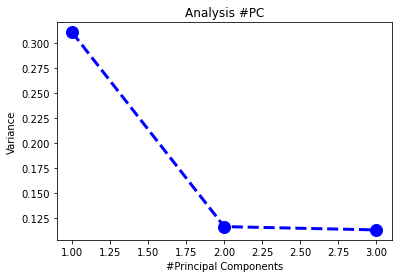

In [41]:
#Visualización en 2D
import matplotlib.pyplot as plt

#plt.plot(num_pc, explained_variance)
plt.plot(num_pc, explained_variance_ratio_, color='blue', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12)

#plt.ylim((0,0.4))
plt.title('Analysis #PC')
plt.xlabel('#Principal Components')
plt.ylabel('Variance')
plt.show()

In [42]:
#Datamining: Clustering (método no supervisado de Machine Learning)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

from sklearn.cluster import KMeans

In [43]:
#Kmeans Clustering 
def doKmeans(X, nclust=3):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(principalDf, 3)
kmeans = pd.DataFrame(clust_labels)
kmeans

,0
0,1
1,1
2,2
3,2
4,2
...,...
124,0
125,0
126,0
127,0


In [44]:
#Datamining: Clustering (método no supervisado de Machine Learning)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

from sklearn.cluster import KMeans

In [45]:
#Kmeans Clustering 
def doKmeans(X, nclust=3):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(principalDf, 3)
kmeans = pd.DataFrame(clust_labels)
kmeans

,0
0,1
1,1
2,2
3,2
4,2
...,...
124,0
125,0
126,0
127,0


Text(0.5, 0, '3ER FACTOR')

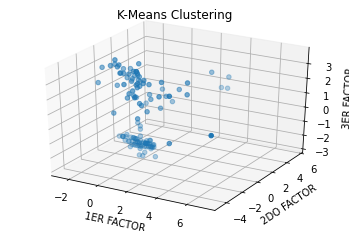

In [46]:

#Visualización de grupos de usuarios en 3D
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(-5, 5, 11)
xline = np.linspace(0, 10, 11)
yline = np.linspace(0, 15, 11)
#ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = principalDf[0]
xdata = principalDf[1]
ydata = principalDf[2]
#ax.scatter3D(xdata, ydata, zdata, c=zdata);
ax.scatter3D(xdata, ydata, zdata);
ax.set_title('K-Means Clustering')
ax.set_xlabel('1ER FACTOR')
ax.set_ylabel('2DO FACTOR')
ax.set_zlabel('3ER FACTOR')

Se creo el archivo con etiquetas
0.1908717230000434


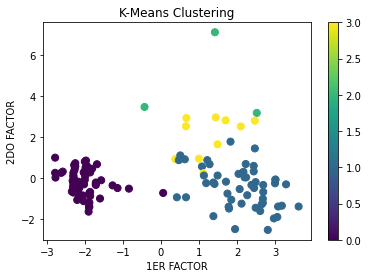

In [47]:
#Visualización de grupos de usuarios en 2D

#determinar el numero de clusters

#Datamining: Clustering (método no supervisado de Machine Learning)
num_clusters=4
clust_labels, cent = doKmeans(principalDf, num_clusters)
kmeans = pd.DataFrame(clust_labels)

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(principalDf[0],principalDf[1],
                     c=kmeans[0],s=50)

ax.set_title('K-Means Clustering')
ax.set_xlabel('1ER FACTOR')
ax.set_ylabel('2DO FACTOR')
plt.colorbar(scatter)

#agregar etiquetas
new_ds= df
new_ds['etiqueta'] = kmeans
new_ds.to_csv('datasetConEtiquetas.csv')
print("Se creo el archivo con etiquetas")

print(timeit("'Hello, world!'.replace('Hello', 'Goodbye')"))